In [201]:
import numpy as np
from utils import *
import matplotlib.pyplot as plt

In [202]:
def load_training_dataset(positive_instances_train, negative_instances_train):
    pos_train, neg_train, vocab = load_training_set(positive_instances_train, negative_instances_train)
    
    return pos_train, neg_train, vocab

In [203]:
def load_testing_dataset(positive_instances_test, negative_instances_test):
    pos_test, neg_test = load_test_set(positive_instances_test, negative_instances_test)
    
    return pos_test, neg_test

In [204]:
def calculate_class_priors(pos_train, neg_train):
    total_docs = len(pos_train) + len(neg_train)
    prior_pos = len(pos_train) / total_docs
    prior_neg = len(neg_train) / total_docs
    
    return prior_pos, prior_neg

In [205]:
def calculate_word_frequencies(pos_train, neg_train, vocab):
    word_counts_pos = {word: 0 for word in vocab}
    word_counts_neg = {word: 0 for word in vocab}
    
    for review in pos_train:
        for word in review:
            if word in vocab:
                word_counts_pos[word] += 1
            
    for review in neg_train:
        for word in review:
            if word in vocab:
                word_counts_neg[word] += 1
                
    return word_counts_pos, word_counts_neg

In [206]:
def test_each_review_posterior(prior_pos, prior_neg, word_counts_pos, word_counts_neg, review, total_pos_word_freq, total_neg_word_freq, alpha):
    test_pos_prob = prior_pos
    test_neg_prob = prior_neg

    for word in review:
        test_pos_prob *= (word_counts_pos.get(word, 0) + alpha) / total_pos_word_freq
        test_neg_prob *= (word_counts_neg.get(word, 0) + alpha) / total_neg_word_freq
    
    if(test_pos_prob > test_neg_prob):
        return 1
    elif(test_neg_prob > test_pos_prob):
        return -1
    else:
        return 2 * np.random.randint(0, 2) - 1

In [207]:
def test_each_review_log(prior_pos, prior_neg, word_counts_pos, word_counts_neg, review, total_pos_word_freq, total_neg_word_freq, alpha):
    log_prob_pos = np.log(max(prior_pos, 1e-8))
    log_prob_neg = np.log(max(prior_neg, 1e-8))
    
    for word in review:
        prob_pos = (word_counts_pos.get(word, 0) + alpha) / total_pos_word_freq
        prob_neg = (word_counts_neg.get(word, 0) + alpha) / total_neg_word_freq

        if prob_pos > 0:
            word_prob_pos = prob_pos
        else:
            word_prob_pos = 1e-8
        log_prob_pos += np.log(word_prob_pos)
        
        if prob_neg > 0:
            word_prob_neg = prob_neg
        else:
            word_prob_neg = 1e-8
        log_prob_neg += np.log(word_prob_neg)
    
    if(log_prob_pos > log_prob_neg):
        return 1
    elif(log_prob_neg > log_prob_pos):
        return -1
    else:
        return 2 * np.random.randint(0, 2) - 1

In [208]:
def test_multinomial_nb(prior_pos, prior_neg, word_counts_pos, word_counts_neg, pos_test, neg_test, prob_type, vocab, alpha):
    total_pos_word_freq = sum(word_counts_pos.values()) + (alpha * len(vocab))
    total_neg_word_freq = sum(word_counts_neg.values()) + (alpha * len(vocab))

    tp, fp, tn, fn = 0, 0, 0, 0
    
    # Testing positive reviews
    for review in pos_test:
        if(prob_type=="posterior"):
            prediction = test_each_review_posterior(prior_pos, prior_neg, word_counts_pos, word_counts_neg, review, total_pos_word_freq, total_neg_word_freq, alpha)
        elif(prob_type=="log"):
            prediction = test_each_review_log(prior_pos, prior_neg, word_counts_pos, word_counts_neg, review, total_pos_word_freq, total_neg_word_freq, alpha)
        if prediction == 1:
            tp += 1
        else:
            fn += 1
    
    # Testing negative reviews
    for review in neg_test:
        if(prob_type=="posterior"):
            prediction = test_each_review_posterior(prior_pos, prior_neg, word_counts_pos, word_counts_neg, review, total_pos_word_freq, total_neg_word_freq, alpha)
        elif(prob_type=="log"):
            prediction = test_each_review_log(prior_pos, prior_neg, word_counts_pos, word_counts_neg, review, total_pos_word_freq, total_neg_word_freq, alpha)
        if prediction == -1:
            tn += 1
        else:
            fp += 1
    
    return tp,tn,fp,fn

In [209]:
def train_multinomial_nb(pos_train, neg_train, vocab):
    prior_pos, prior_neg = calculate_class_priors(pos_train, neg_train)
    word_counts_pos, word_counts_neg = calculate_word_frequencies(pos_train, neg_train, vocab)
    
    return prior_pos, prior_neg, word_counts_pos, word_counts_neg

In [210]:
def calculate_eval_metrics(tp, tn, fp, fn, prob_type, alpha):
    confusion_matrix  = [[tp, fp], [tn, fn]]
    accuracy = (tn+tp)/(tn+fp+tp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    return accuracy, confusion_matrix, precision, recall

In [211]:
def startAlgo(train_count_pos, train_count_neg, test_count_pos, test_count_neg, prob_type, alpha):
    pos_train, neg_train, vocab = load_training_dataset(train_count_pos, train_count_neg)
    pos_test, neg_test = load_testing_dataset(test_count_pos, test_count_neg)

    prior_pos, prior_neg,word_counts_pos, word_counts_neg = train_multinomial_nb(pos_train, neg_train, vocab)

    tp,tn,fp,fn = test_multinomial_nb(prior_pos, prior_neg, word_counts_pos, word_counts_neg, pos_test, neg_test, prob_type, vocab, alpha)

    accuracy, confusion_matrix, precision, recall = calculate_eval_metrics(tp, tn, fp, fn, prob_type, alpha)

    return accuracy, confusion_matrix, precision, recall

In [212]:
def plot_accuracy_graph(alphas, accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, accuracies, marker='o', linestyle='-', color='b')
    plt.xscale('log')
    plt.xlabel('Alpha (α)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Alpha (Laplace Smoothing Parameter)')
    plt.grid(True)
    plt.show()

In [213]:
def print_data(accuracy, confusion_matrix, precision, recall, prob_type):
    print("******************RESULTS FOR {} model******************".format(prob_type))
    print("Accuracy: ", accuracy)
    print("Confusion Matrix [[tp, fp], [tn, fn]]: ", confusion_matrix) 
    print("Precision: ", precision)
    print("Recall: ", recall)

=====================================Q1=====================================


******************RESULTS FOR posterior model******************
Accuracy:  0.5294587577391652
Confusion Matrix [[tp, fp], [tn, fn]]:  [[1270, 1180], [1381, 1176]]
Precision:  0.5183673469387755
Recall:  0.5192150449713818
******************RESULTS FOR log model******************
Accuracy:  0.7467608951707891
Confusion Matrix [[tp, fp], [tn, fn]]:  [[1795, 538], [2009, 752]]
Precision:  0.7693956279468496
Recall:  0.7047506870828426
=====================================Q2=====================================
******************RESULTS FOR log model******************
Accuracy:  0.8205794205794206
Confusion Matrix [[tp, fp], [tn, fn]]:  [[1871, 279], [2236, 619]]
Precision:  0.8702325581395349
Recall:  0.7514056224899598


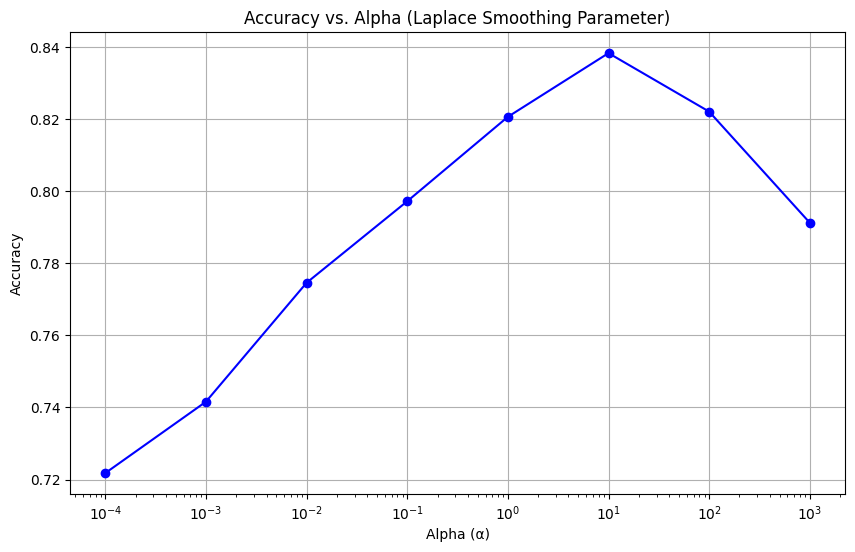

=====================================Q3=====================================
******************RESULTS FOR posterior model******************
Accuracy:  0.66264
Confusion Matrix [[tp, fp], [tn, fn]]:  [[7878, 3812], [8688, 4622]]
Precision:  0.6739093242087254
Recall:  0.63024
******************RESULTS FOR log model******************
Accuracy:  0.83692
Confusion Matrix [[tp, fp], [tn, fn]]:  [[9924, 1501], [10999, 2576]]
Precision:  0.8686214442013129
Recall:  0.79392
=====================================Q4=====================================
******************RESULTS FOR posterior model******************
Accuracy:  0.65864
Confusion Matrix [[tp, fp], [tn, fn]]:  [[7818, 3852], [8648, 4682]]
Precision:  0.6699228791773779
Recall:  0.62544
******************RESULTS FOR log model******************
Accuracy:  0.83512
Confusion Matrix [[tp, fp], [tn, fn]]:  [[9882, 1504], [10996, 2618]]
Precision:  0.8679079571403477
Recall:  0.79056
=====================================Q6=================

In [214]:
#Q1
print("=====================================Q1=====================================")
accuracy, confusion_matrix, precision, recall = startAlgo(0.2, 0.2, 0.2, 0.2, "posterior", 0)
print_data(accuracy, confusion_matrix, precision, recall, "posterior")
accuracy, confusion_matrix, precision, recall = startAlgo(0.2, 0.2, 0.2, 0.2, "log", 0)
print_data(accuracy, confusion_matrix, precision, recall, "log")

#Q2
print("=====================================Q2=====================================")
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
accuracies = []
for alpha in alphas:
    accuracy, confusion_matrix, precision, recall = startAlgo(0.2, 0.2, 0.2, 0.2, "log", alpha)
    accuracies.append(accuracy)
    if(alpha==1):
        print_data(accuracy, confusion_matrix, precision, recall, "log")
plot_accuracy_graph(alphas, accuracies)

#Q3
print("=====================================Q3=====================================")
accuracy, confusion_matrix, precision, recall = startAlgo(1, 1, 1, 1, "posterior", 10)
print_data(accuracy, confusion_matrix, precision, recall, "posterior")
accuracy, confusion_matrix, precision, recall = startAlgo(1, 1, 1, 1, "log", 10)
print_data(accuracy, confusion_matrix, precision, recall, "log")

#Q4
print("=====================================Q4=====================================")
accuracy, confusion_matrix, precision, recall = startAlgo(0.5, 0.5, 1, 1, "posterior", 10)
print_data(accuracy, confusion_matrix, precision, recall, "posterior")
accuracy, confusion_matrix, precision, recall = startAlgo(0.5, 0.5, 1, 1, "log", 10)
print_data(accuracy, confusion_matrix, precision, recall, "log")

#Q6
print("=====================================Q6=====================================")
accuracy, confusion_matrix, precision, recall = startAlgo(0.1, 0.5, 1, 1, "posterior", 10)
print_data(accuracy, confusion_matrix, precision, recall, "posterior")
accuracy, confusion_matrix, precision, recall = startAlgo(0.1, 0.5, 1, 1, "log", 10)
print_data(accuracy, confusion_matrix, precision, recall, "log")